<a href="https://colab.research.google.com/github/georgezefko/Twitter-Sentiment-Analysis/blob/main/Text_Classification_LSTM_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk import sent_tokenize
from sklearn.utils import resample
import unicodedata
import string
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_data = '/content/drive/MyDrive/disaster_tweet/'
train = pd.read_csv(train_data+'train.csv')
test = pd.read_csv(train_data+'test.csv')

In [4]:
#save only the text and target data drop the unnecessary columns
train = train.drop(['id','keyword','location'], axis=1)
test = test.drop(['id','keyword','location'], axis=1)

In [5]:
STOPWORDS = nltk.corpus.stopwords.words('english')

def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\b\w\b', ' ', text)
    text = re.sub('@[^\s]+','',text)
    text = emoji_pattern.sub(r'', text)       
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS if len(word)>=3) # remove stopwords from text

    return text


def tokenize(text):
  tokens = nltk.word_tokenize(text)
  return tokens

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  lem_list = [lemmatizer.lemmatize(word) for word in text]
  return lem_list

def rejoin_words(text):
  joined_words = (" ".join(text))
  return joined_words

In [6]:
train['text']=train['text'].apply(clean_text)
train['text']=train['text'].apply(tokenize)
train['text']=train['text'].apply(lemmatize)
train['text']=train['text'].apply(rejoin_words)

In [12]:
train_sentences = train['text'].values
train_labels = train['target'].values

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_sentences, train_labels, test_size=0.2)

In [14]:
maxLen = len(max(X_train, key=len).split())

In [15]:
maxLen

21

In [16]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [17]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/disaster_tweet/glove.6B.50d.txt')

In [18]:
def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0] # number of training examples
    
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          if w not in word_to_index: #needs to be fixed
              w = 'unk'
            # Set the (i,j)th entry of X_indices to the index of the correct word.
          X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
          j = j + 1
            
    
    
    return X_indices

In [19]:
X1 = np.array(["funny lol", "lets play baseball siouxlan", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball siouxlan' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714. 372306.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [20]:
X2 = X_train[2:4]
X2_indices = sentences_to_indices(X2,word_to_index, maxLen )
print("X1 =", X2)
print("X1_indices =\n", X2_indices)

X1 = ['every bts song jimin scream'
 'new type adhd head injury child linked long term attention problem']
X1_indices =
 [[141941.  85744. 337465. 197746. 322154.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]
 [259972. 368669.  46435. 175207. 190227.  98970. 223138. 225289. 356157.
   62719. 292794.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]]


In [21]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    
   
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

   
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    
    embedding_layer.build((None,)) 
    
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [22]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [23]:
def tweet_classifier(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(input_shape, dtype='int32')
    
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)   
    
    
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    X = Dropout(0.3)(X)
    
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    
    X = Dropout(0.3)(X)
    
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    
    X = Dropout(0.3)(X)
    X = Dense(1)(X)
    
    X = Activation('sigmoid')(X)
    
    model = Model(sentence_indices, X)
    
   
    
    return model

In [24]:
model = tweet_classifier((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 21, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 256)           183296    
_________________________________________________________________
dropout (Dropout)            (None, 21, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240

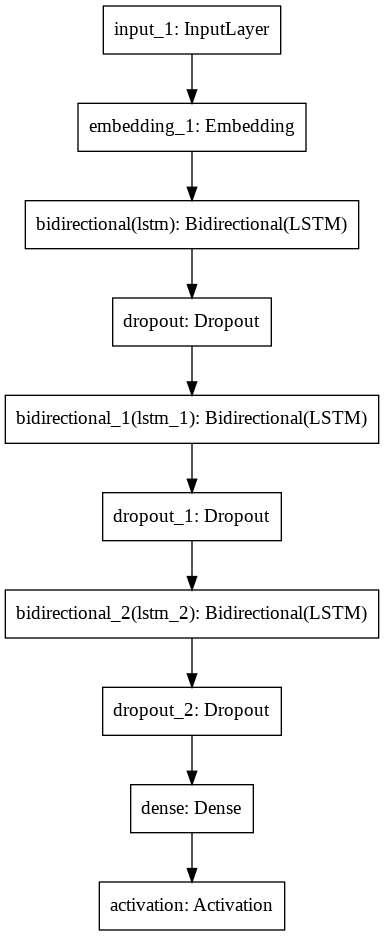

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen )
X_valid_indices = sentences_to_indices(X_valid, word_to_index, maxLen )


In [27]:
history = model.fit(X_train_indices, y_train, epochs = 50, batch_size = 32,shuffle=True, validation_data=(X_valid_indices, y_valid))

Epoch 1/50
191/191 [==============================] - 60s 261ms/step - loss: 0.5170 - accuracy: 0.7525 - val_loss: 0.4477 - val_accuracy: 0.8070
Epoch 2/50
191/191 [==============================] - 46s 241ms/step - loss: 0.4482 - accuracy: 0.8035 - val_loss: 0.4684 - val_accuracy: 0.8004
Epoch 3/50
191/191 [==============================] - 45s 236ms/step - loss: 0.4309 - accuracy: 0.8150 - val_loss: 0.4422 - val_accuracy: 0.8063
Epoch 4/50
191/191 [==============================] - 44s 231ms/step - loss: 0.4181 - accuracy: 0.8169 - val_loss: 0.4695 - val_accuracy: 0.8043
Epoch 5/50
191/191 [==============================] - 45s 234ms/step - loss: 0.4208 - accuracy: 0.8221 - val_loss: 0.4421 - val_accuracy: 0.8096
Epoch 6/50
191/191 [==============================] - 44s 233ms/step - loss: 0.3624 - accuracy: 0.8448 - val_loss: 0.4479 - val_accuracy: 0.8109
Epoch 7/50
191/191 [==============================] - 44s 232ms/step - loss: 0.3443 - accuracy: 0.8535 - val_loss: 0.4497 - val_ac

In [28]:
X_test_indices = sentences_to_indices(X_valid, word_to_index, max_len = 21 )

loss, acc = model.evaluate(X_test_indices, y_valid)
print()
print("Test accuracy = ", acc)

48/48 [==============================] - 3s 59ms/step - loss: 1.3778 - accuracy: 0.7814

Test accuracy =  0.7813525795936584


In [29]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

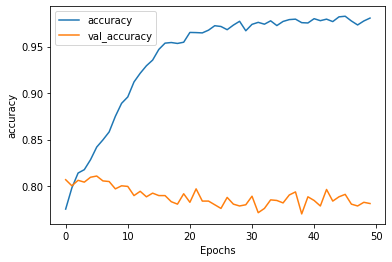

In [30]:
plot_graphs(history,'accuracy')

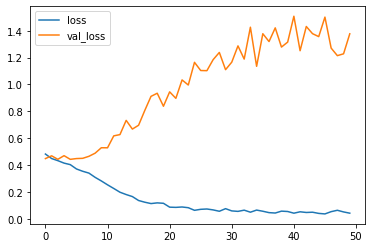

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [32]:
test['text']=test['text'].apply(clean_text)
test['text']=test['text'].apply(tokenize)
test['text']=test['text'].apply(lemmatize)
test['text']=test['text'].apply(rejoin_words)
test_sentences = test['text'].values

In [33]:
maxLen = len(max(test_sentences, key=len).split())
X_test_indices = sentences_to_indices(test_sentences, word_to_index, 21)
y = model.predict(X_test_indices).round()
y_final = y.astype(int)

In [34]:
X_test_indices

array([[173063., 356326.,  91624., ...,      0.,      0.,      0.],
       [175426., 132523., 123767., ...,      0.,      0.,      0.],
       [151580., 148728., 340109., ...,      0.,      0.,      0.],
       ...,
       [166484., 222946., 121383., ...,      0.,      0.,      0.],
       [239818., 193637., 175016., ...,      0.,      0.,      0.],
       [372306.,  45856., 252973., ...,      0.,      0.,      0.]])

In [35]:
y_final

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [36]:
pred = pd.DataFrame(y_final,columns=['target'])

In [37]:
pred['target'].value_counts()

0    1962
1    1301
Name: target, dtype: int64

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/disaster_tweet/sample_submission.csv')
sample_submission['target'] = pred

In [ ]:
sample_submission['target'].head(20)

0     1
1     1
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    0
14    0
15    1
16    0
17    0
18    0
19    0
Name: target, dtype: int64

In [ ]:

submission_4 = sample_submission.to_csv('submission_4.csv', index=False)


In [ ]:
sample_ = pd.read_csv('/content/submission_4.csv')


In [ ]:
sample_.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
